# Evaluating Imputation on Ground Truth

## Simulating a Dataset

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import math
import time

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

from pyproteonet.simulation import molecule_set_from_degree_distribution, simulate_protein_peptide_dataset
from pyproteonet.aggregation import maxlfq, partner_top_n_mean

# We define some degree distributions roughly assembling those of a real world dataset
protein_deg_distribution = [0, 0.1445, 0.1221, 0.1151, 0.0933, 0.0692, 0.0655, 0.0508, 0.0472, 0.0362, 0.0311, 0.0277, 0.0209, 0.0199, 0.0163, 0.0143,
                            0.012, 0.0105, 0.0093, 0.0087, 0.0081, 0.0063, 0.0063, 0.0055, 0.0054, 0.0043, 0.0043, 0.0042, 0.0039, 0.0037, 0.0034,
                            0.0031, 0.0022, 0.0021, 0.0019, 0.0019, 0.0019, 0.0015, 0.0012, 0.001, 0.001]
peptide_deg_distribution = [0, 0.9591, 0.0341, 0.0046, 0.0014]

In [122]:
eval_protein_numbers = [100]
eval_sample_numbers = [5, 10, 20, 30, 40, 50, 60, 70]
num_runs = 3
runtimes_maxlfq = dict()
runtimes_top3 = dict()

with tqdm(total = len(eval_protein_numbers) * len(eval_sample_numbers) * num_runs) as pbar:
    for run in range(num_runs):
        for num_proteins in eval_protein_numbers:
            for num_samples in eval_sample_numbers:
                times_maxlfq = runtimes_maxlfq.get((num_proteins, num_samples), [])
                times_top3 = runtimes_top3.get((num_proteins, num_samples), [])
                protein_degs = np.round(num_proteins * np.array(protein_deg_distribution))
                prot_edges = np.sum(np.arange(len(protein_deg_distribution)) * protein_degs)

                num_peptides = 1
                pep_edges = 0
                while pep_edges < prot_edges:
                    num_peptides += 1
                    peptide_degs = np.round(num_peptides * np.array(peptide_deg_distribution))
                    pep_edges = np.sum(np.arange(len(peptide_deg_distribution)) * peptide_degs)
                if pep_edges > prot_edges:
                    diff = pep_edges - prot_edges
                    for i in range(len(peptide_degs)-1, -1, -1):
                        if peptide_degs[i] > 0 and i <= diff:
                            peptide_degs[i] -= 1
                            diff -= i
                        if diff == 0:
                            break
                ms = molecule_set_from_degree_distribution(protein_degree_distribution=protein_degs, peptide_degree_distribution=peptide_degs)
                ds = simulate_protein_peptide_dataset(molecule_set=ms, mapping='peptide-protein', samples=num_samples)
                start = time.time()
                aggregated = maxlfq(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance')
                end  = time.time()
                times_maxlfq.append(end - start)
                start = time.time()
                aggregated = partner_top_n_mean(top_n=3, dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance')
                end  = time.time()
                times_top3.append(end - start)
                runtimes_maxlfq[(num_proteins, num_samples)] = times_maxlfq
                runtimes_top3[(num_proteins, num_samples)] = times_top3
                pbar.update(1)

  0%|          | 0/24 [00:00<?, ?it/s]

<Axes: xlabel='samples', ylabel='time'>

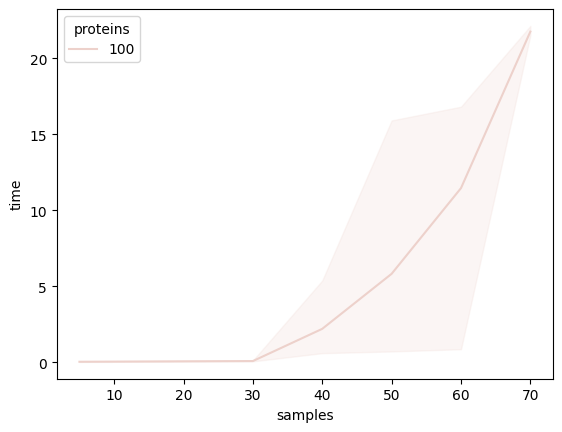

In [123]:
prots, samples, times, runs = [], [], [], []
for key, value in runtimes_maxlfq.items():
    prot, sample = key
    for run, t in enumerate(value):
        prots.append(prot)
        samples.append(sample)
        times.append(t)
        runs.append(run)
df = pd.DataFrame({'proteins': prots, 'samples': samples, 'time': times, 'run': runs, 'method': 'maxlfq'})
sns.lineplot(data=df, x='samples', y='time', hue='proteins')

<Axes: xlabel='samples', ylabel='time'>

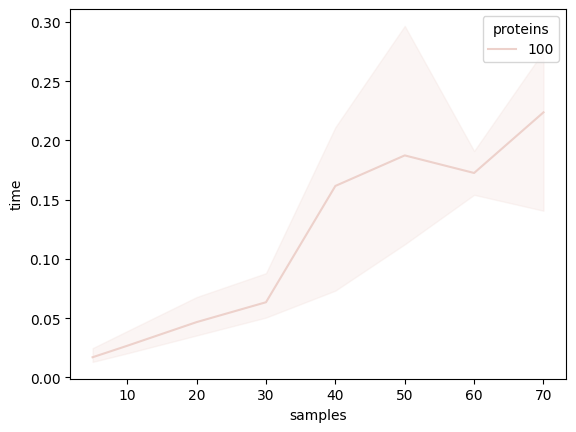

In [124]:
prots, samples, times, runs = [], [], [], []
for key, value in runtimes_top3.items():
    prot, sample = key
    for run, t in enumerate(value):
        prots.append(prot)
        samples.append(sample)
        times.append(t)
        runs.append(run)
df = pd.DataFrame({'proteins': prots, 'samples': samples, 'time': times, 'run': runs, 'method': 'top3'})
sns.lineplot(data=df, x='samples', y='time', hue='proteins')

In [65]:
maxlfq(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance')

/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/aggregation/maxlfq.py:219: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


sample   id
sample0  0      1496.000000
sample1  0       666.000000
sample2  0      1513.000000
sample3  0       699.000000
sample4  0       979.000000
                   ...     
sample5  96     7653.254714
sample6  96    16959.800281
sample7  96    13010.314567
sample8  96    10349.372874
sample9  96    15561.434681
Length: 970, dtype: float64

## Protein Aggregation

Since in proteomics it is often worked with logarithmic abundance values, also the peptide abundances of our artifical dataset should first be logarithmized.

This also helps to understand how to access and modify dataset values in PyProteoNet. One convinient way shown here is to access a single value field or column as padas DataFrame in long format, containing all abundance values with their sample and protein id as multi index. Logarithmization can then be done as shown below, saving the logarithmized values under a new column.

In [8]:
ds.values['peptide']['abundance_log'] = np.log(ds.values['peptide']['abundance'])

Usually we are interested in protein abundances. Therefore, the measured peptide abundance values need to be aggregated into protein abundance values.
This is done via the peptide-protein mapping using an aggregation function (also called quantification function).

Here we apply Top3 aggregation as a simple but commonly used aggregation function. This function computes protein abundance from the average of the three most abundant peptides corresponding to a protein. In real-world datasets some peptides are usually shared between different proteins. Since their abundance values cannot be uniquly assigned to a protein, shared peptides are often ignored during abundane aggregation and only unique peptides are considered.

The result is represented as a pandas Series in long format with a multiindex to identify samples and protein ids.

In [9]:
from pyproteonet.aggregation.partner_summarization import partner_top_n_mean
top3 = partner_top_n_mean(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_log',
                          top_n=3, only_unique=True)

In [10]:
top3

sample   id
sample0  0     9.059397
         1     8.859051
         2     8.874540
         3     9.097946
         4     9.098969
         5     9.060221
         6     8.963788
         7     9.077467
         8     9.107079
         9     9.101319
sample1  0     8.846131
         1     8.795575
         2     9.124960
         3     8.886239
         4     8.785984
         5     9.127745
         6     9.154690
         7     9.043791
         8     9.066401
         9     8.896717
sample2  0     8.837659
         1     8.705259
         2     9.114073
         3     9.008667
         4     9.100431
         5     9.021828
         6     9.163367
         7     9.021873
         8     9.092699
         9     8.898715
Name: quanti, dtype: float64

To assign this to our dataset the following syntax can be used:

In [11]:
ds.values['protein']['top3'] = top3

Alternatively, most functions also allow the direct specification of a result column. So an alternative formulation of the Top3 aggregation could be as follows:

In [12]:
_ = partner_top_n_mean(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_log',
                       top_n=3, only_unique=True, result_column='top3')

The long format of the Top3 aggregated protein abundance values is little intuitive and a matrix representation is often used instead. Therefore, the `Dataset` class provides functions to represent data in different formats allowing. To get the Top3 results as a pandas DataFrame with samples as columns ans proteins as rows the `get_samples_value_matrix` function can be useful:

In [13]:
ds.get_samples_value_matrix(molecule='protein', column='top3')

,sample0,sample1,sample2
id,,,
0,9.059397,8.846131,8.837659
1,8.859051,8.795575,8.705259
2,8.874540,9.124960,9.114073
3,9.097946,8.886239,9.008667
4,9.098969,8.785984,9.100431
5,9.060221,9.127745,9.021828
6,8.963788,9.154690,9.163367
7,9.077467,9.043791,9.021873
8,9.107079,9.066401,9.092699


Next to the rather simple neighbor average (Top3), PyProteoNet also provides an efficient implementation of the more complex MaxLFQ protein aggregation method propose by [Cox et al.](https://www.mcponline.org/article/S1535-9476(20)33310-7/fulltext).

This methods takes peptide abundance ratios between all samples into account and then solves a least squares optimization probel to find protein abundance values best representing the observed peptide abundances. 
Similar to [Cox et al.](https://www.mcponline.org/article/S1535-9476(20)33310-7/fulltext) we here require at least two non missing peptide abundances. Additionally, we need to specify that the given values are already logarithmic to allows the correct calculation of peptide ratios between samples.

In [14]:
from pyproteonet.aggregation import maxlfq
_ = maxlfq(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_log',
           min_ratios=2, median_fallback=False, result_column='maxlfq', is_log=True)

/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/aggregation/maxlfq.py:219: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


Next to the matrix representation we can also look at all columns of a molecule using its long format representation as pandas DataFrame with multiindex. To do so we can again use the `values` attribute of our dataset. Using the `df` shortcut, we get a DataFrame of all columns for a molecule type in long format.

In [15]:
ds.values['protein'].df

top3    maxlfq
sample  id                    
sample0 0   9.059397  8.570981
        1   8.859051  8.004946
        2   8.874540  8.222338
        3   9.097946  8.542716
        4   9.098969  8.271626
        5   9.060221  8.327767
        6   8.963788  7.879674
        7   9.077467  8.441515
        8   9.107079  8.292413
        9   9.101319  8.261357
sample1 0   8.846131  7.742310
        1   8.795575  7.389677
        2   9.124960  8.699787
        3   8.886239  8.063417
        4   8.785984  8.056610
        5   9.127745  8.361637
        6   9.154690  7.820593
        7   9.043791  8.483310
        8   9.066401  8.277093
        9   8.896717  7.750524
sample2 0   8.837659  7.982651
        1   8.705259  7.872761
        2   9.114073  8.629805
        3   9.008667  8.491207
        4   9.100431  8.043956
        5   9.021828  8.466973
        6   9.163367  8.434427
        7   9.021873  8.569465
        8   9.092699  8.335110
        9   8.898715  7.804313

## Missing Value Imputation

Pyproteonet provides a wide range of established as well as newly proposed, graph neural network (GNN) based missing value imputation functions.

The interface for most imputation functions is similar to this of the aggregation functions shown above. Next to a dataset you need to provide the molecole type as well as the column(s) to impute and, optionally, values for method specific hyperparameters.

Of course, for imputation, we first of all need some missing values. So for our example we just mask some of the Top3 values. To do so we, again, use the `values` attribute of our dataset to get all Top3 values as pandas DataFrame in long format. Then, we replace some of the values with `Na` using pandas and, finally, we write the result back as a new column in our dataset

In [16]:
vals = ds.values['protein']['top3']
vals.loc[vals.sample(frac=0.33).index] = np.nan
ds.values['protein']['top3_masked'] = vals

In [17]:
ds.values['protein'].df

top3    maxlfq  top3_masked
sample  id                                 
sample0 0   9.059397  8.570981          NaN
        1   8.859051  8.004946     8.859051
        2   8.874540  8.222338          NaN
        3   9.097946  8.542716          NaN
        4   9.098969  8.271626     9.098969
        5   9.060221  8.327767          NaN
        6   8.963788  7.879674     8.963788
        7   9.077467  8.441515     9.077467
        8   9.107079  8.292413          NaN
        9   9.101319  8.261357     9.101319
sample1 0   8.846131  7.742310          NaN
        1   8.795575  7.389677     8.795575
        2   9.124960  8.699787          NaN
        3   8.886239  8.063417     8.886239
        4   8.785984  8.056610          NaN
        5   9.127745  8.361637     9.127745
        6   9.154690  7.820593     9.154690
        7   9.043791  8.483310     9.043791
        8   9.066401  8.277093     9.066401
        9   8.896717  7.750524     8.896717
sample2 0   8.837659  7.982651     8.837659
        1   8.705259  7.872761     8.705259
        2   9.114073  8.629805     9.114073
        3   9.008667  8.491207          NaN
        4   9.100431  8.043956     9.100431
        5   9.021828  8.466973     9.021828
        6   9.163367  8.434427     9.163367
        7   9.021873  8.569465     9.021873
        8   9.092699  8.335110     9.092699
        9   8.898715  7.804313          NaN

Let's use the commonly used MissForrest imputation algorithm to impute the missing values

In [20]:
from pyproteonet.imputation.r.miss_forest import miss_forest_impute

ds.values['protein']['top3_imputed'] = miss_forest_impute(dataset=ds, molecule='protein', column='top3_masked')

Looking at the result we can see that the missing values are gone:

In [21]:
ds.values['protein'].df

top3  maxlfq  top3_masked  top3_imputed
sample  id                                         
sample0 0  9.059   8.571          NaN         9.038
        1  8.859   8.005        8.859         8.859
        2  8.875   8.222          NaN         9.038
        3  9.098   8.543          NaN         9.038
        4  9.099   8.272        9.099         9.099
        5  9.060   8.328          NaN         9.092
        6  8.964   7.880        8.964         8.964
        7  9.077   8.442        9.077         9.077
        8  9.107   8.292          NaN         9.075
        9  9.101   8.261        9.101         9.101
sample1 0  8.846   7.742          NaN         9.009
        1  8.796   7.390        8.796         8.796
        2  9.125   8.700          NaN         9.009
        3  8.886   8.063        8.886         8.886
        4  8.786   8.057          NaN         9.100
        5  9.128   8.362        9.128         9.128
        6  9.155   7.821        9.155         9.155
        7  9.044   8.483        9.044         9.044
        8  9.066   8.277        9.066         9.066
        9  8.897   7.751        8.897         8.897
sample2 0  8.838   7.983        8.838         8.838
        1  8.705   7.873        8.705         8.705
        2  9.114   8.630        9.114         9.114
        3  9.009   8.491          NaN         9.004
        4  9.100   8.044        9.100         9.100
        5  9.022   8.467        9.022         9.022
        6  9.163   8.434        9.163         9.163
        7  9.022   8.569        9.022         9.022
        8  9.093   8.335        9.093         9.093
        9  8.899   7.804          NaN         8.983

If you look at the import of the impute_miss_forest function you will notice that this function is part of the "r" subpackage.
Most established imputation algorithms are implemented in the R programming language and provided as R packages. To also provide those algorithms while maintaining a unified Python interfact PyProteoNet wraps those R packages. 
Therefore, all algorithms in the "r" subpackage require an existing R installation (if you use a conda/mamba environment you could simply install one with the command `conda install -c conda-forge r-base`). For the user it is transparent whether an imputation function is implemented in Python or wrapped from an R package. All installation of R dependencies and conversion of data types between Python and R is done in the background by PyProteoNet (internally the rpy2 package is used for this).

> **Note**: Compared to other proteomics- or imputation-focused packages PyProteoNet allows to jointly manage protein and peptide values as well as the relation between them (plus any other additional molecule types if required). This together with the implemented aggragation and imputation functions allows for a more versatile usage scenarios. E.g. imputation can be applied both on peptide level (before aggregation) as well as on protein level (after aggregation). In addition, the application and comparision of different imputation algorithmis and stratigies on the same dataset is facilitated

## Graph Neural Network Imputation

While traditionally, imputation is either applied on peptide OR on protein level modelling protein and peptides a graph structure allows for flexilbe imputation strategies jointly taking information from both molecules into account. Therefore, imputation is formulated as a regression problem on the protein-peptide graph which is then solved by training a graph neural network (GNN).

While PyProteoNet provides different flavors and implementations using different network architectures and training schemes for the underlying GNN, those imputation methods can be called via a similar interface as other imputation methods.
Since two types of molecules (proteins and peptides) are taken into account, the name of those molecule types as well as two value columns have to be specified.

Additional hyperparameters can be set aswell (here set to values used for real-world datasets)

In [25]:
from pyproteonet.imputation.dnn.gnn import impute_heterogeneous_gnn

impute_heterogeneous_gnn(dataset=ds, molecule='protein', column='top3_masked', mapping='peptide-protein', partner_column='abundance_log',
                         molecule_result_column=f'gnn_hetero', partner_result_column=f'gnn_hetero',
                         max_epochs=1000, early_stopping_patience=7, epoch_size=30, training_fraction=0.25, log_every_n_steps=30)

seed: 401954812


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type            | Params
------------------------------------------------------
0 | embedding         | Embedding       | 40    
1 | molecule_fc_model | Sequential      | 1.1 K 
2 | partner_fc_model  | Sequential      | 1.1 K 
3 | molecule_gat      | HeteroGraphConv | 1.1 K 
4 | partner_gat       | HeteroGraphConv | 1.5 K 
5 | molecule_gat2     | HeteroGraphConv | 1.9 K 
6 | molecule_linear   | Linear          | 78    
7 | partner_linear    | Linear          | 114   
8 | loss_fn           | GaussianNLLLoss | 0     
------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)


Training: |                                                                                                   …

attention exploding loss: 1.222819447517395
attention exploding loss: 1.323311448097229
attention exploding loss: 1.2195301055908203
attention exploding loss: 1.430880069732666
attention exploding loss: 1.241489052772522
attention exploding loss: 1.2212234735488892
step29: num_masked_molecule:20.0 || num_masked_partner:73.16666412353516 || molecule_loss:0.48725736141204834 || partner_loss:0.5270040035247803 || train_loss:0.9967511296272278 || epoch:0 || 
attention exploding loss: 1.2357163429260254
step59: num_masked_molecule:20.0 || num_masked_partner:78.0 || molecule_loss:0.47434988617897034 || partner_loss:0.4693260192871094 || train_loss:0.9421185255050659 || epoch:1 || 
attention exploding loss: 1.2734850645065308
step89: num_masked_molecule:20.0 || num_masked_partner:70.06666564941406 || molecule_loss:0.4627026617527008 || partner_loss:0.4725511372089386 || train_loss:0.9324373006820679 || epoch:2 || 
attention exploding loss: 1.3412872552871704
step119: num_masked_molecule:20.0 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


step1079: num_masked_molecule:20.0 || num_masked_partner:74.4000015258789 || molecule_loss:-0.33426129817962646 || partner_loss:0.4511387050151825 || train_loss:0.11305632442235947 || epoch:35 || 


Predicting: |                                                                                                 …

sample   id
sample0  0    9.050
sample1  0    8.966
sample2  0    8.838
sample0  1    8.859
sample1  1    8.796
sample2  1    8.705
sample0  2    9.009
sample1  2    9.124
sample2  2    9.114
sample0  3    8.990
sample1  3    8.886
sample2  3    8.862
sample0  4    9.099
sample1  4    9.071
sample2  4    9.100
sample0  5    9.039
sample1  5    9.128
sample2  5    9.022
sample0  6    8.964
sample1  6    9.155
sample2  6    9.163
sample0  7    9.077
sample1  7    9.044
sample2  7    9.022
sample0  8    9.041
sample1  8    9.066
sample2  8    9.093
sample0  9    9.101
sample1  9    8.897
sample2  9    8.985
dtype: float64

In [26]:
ds.values['protein'].df

top3  maxlfq  top3_masked  top3_imputed  gnn_hetero_samples  \
sample  id                                                                
sample0 0  9.059   8.571          NaN         9.038               9.020   
        1  8.859   8.005        8.859         8.859               8.859   
        2  8.875   8.222          NaN         9.038               9.018   
        3  9.098   8.543          NaN         9.038               9.019   
        4  9.099   8.272        9.099         9.099               9.099   
        5  9.060   8.328          NaN         9.092               9.019   
        6  8.964   7.880        8.964         8.964               8.964   
        7  9.077   8.442        9.077         9.077               9.077   
        8  9.107   8.292          NaN         9.075               9.019   
        9  9.101   8.261        9.101         9.101               9.101   
sample1 0  8.846   7.742          NaN         9.009               8.996   
        1  8.796   7.390        8.796         8.796               8.796   
        2  9.125   8.700          NaN         9.009               8.995   
        3  8.886   8.063        8.886         8.886               8.886   
        4  8.786   8.057          NaN         9.100               8.995   
        5  9.128   8.362        9.128         9.128               9.128   
        6  9.155   7.821        9.155         9.155               9.155   
        7  9.044   8.483        9.044         9.044               9.044   
        8  9.066   8.277        9.066         9.066               9.066   
        9  8.897   7.751        8.897         8.897               8.897   
sample2 0  8.838   7.983        8.838         8.838               8.838   
        1  8.705   7.873        8.705         8.705               8.705   
        2  9.114   8.630        9.114         9.114               9.114   
        3  9.009   8.491          NaN         9.004               9.007   
        4  9.100   8.044        9.100         9.100               9.100   
        5  9.022   8.467        9.022         9.022               9.022   
        6  9.163   8.434        9.163         9.163               9.163   
        7  9.022   8.569        9.022         9.022               9.022   
        8  9.093   8.335        9.093         9.093               9.093   
        9  8.899   7.804          NaN         8.983               9.007   

            gnn_hetero  
sample  id              
sample0 0        9.050  
        1        8.859  
        2        9.009  
        3        8.990  
        4        9.099  
        5        9.039  
        6        8.964  
        7        9.077  
        8        9.041  
        9        9.101  
sample1 0        8.966  
        1        8.796  
        2        9.124  
        3        8.886  
        4        9.071  
        5        9.128  
        6        9.155  
        7        9.044  
        8        9.066  
        9        8.897  
sample2 0        8.838  
        1        8.705  
        2        9.114  
        3        8.862  
        4        9.100  
        5        9.022  
        6        9.163  
        7        9.022  
        8        9.093  
        9        8.985